Import the # libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

Import the dataset

Dataset Link: http://www.kaggle.com/datasets/akshatgupta7/crop-yield-in-indian-states-dataset

In [2]:
FILENAME = ''

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        FILENAME = os.path.join(dirname, filename)

In [3]:
dataset = pd.read_csv(FILENAME)

dataset.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [4]:
dataset.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


There are a total of 19689 entries

In [5]:
dataset['Crop'] = dataset['Crop'].str.strip()
dataset['Season'] = dataset['Season'].str.strip()
dataset['State'] = dataset['State'].str.strip()

Stripping the whitespace before and after all string data

In [6]:
print(f"Number of unique crops: {dataset['Crop'].nunique()}")
print(f"Number of unique seasons: {dataset['Season'].nunique()}")
print(f"Number of unique states: {dataset['State'].nunique()}")

Number of unique crops: 55
Number of unique seasons: 6
Number of unique states: 30


Plotting count of each crop, season, state

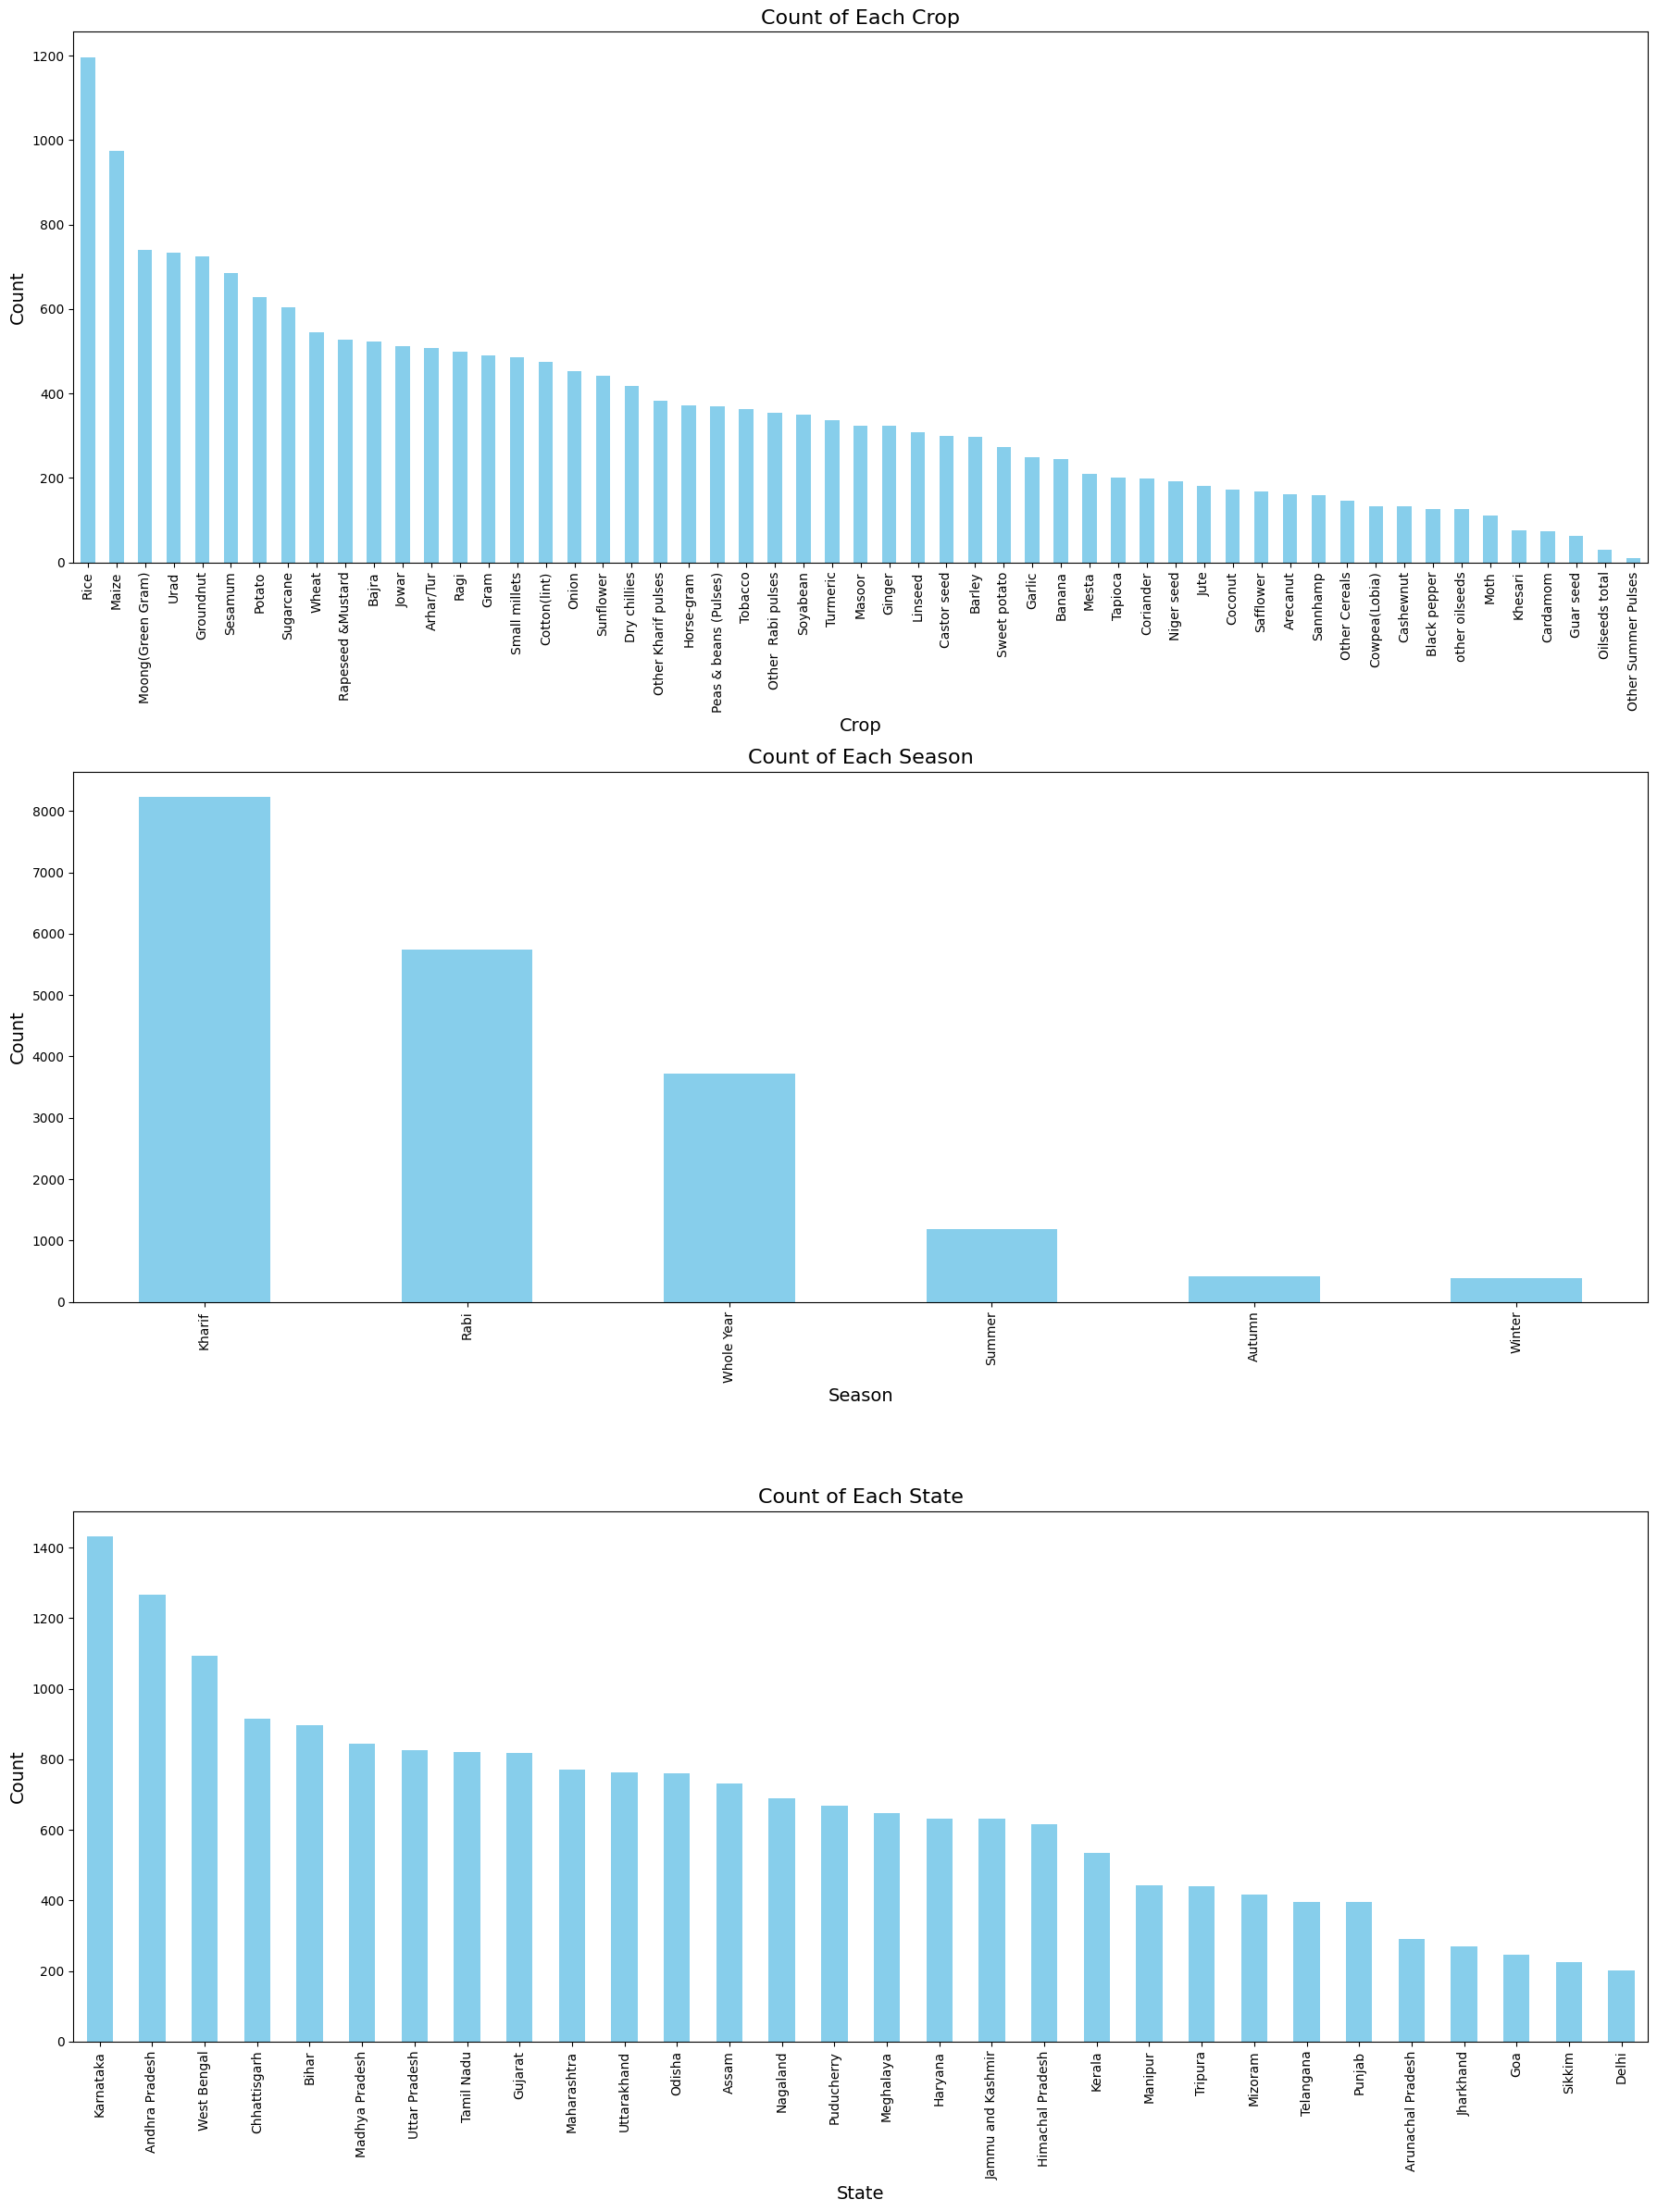

In [7]:
crop_counts = dataset['Crop'].value_counts()
season_counts = dataset['Season'].value_counts()
state_counts = dataset['State'].value_counts()

fig, axes = plt.subplots(3, 1, figsize=(18, 24))

crop_counts.plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_xlabel("Crop", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].set_title("Count of Each Crop", fontsize=16)
axes[0].tick_params(axis='x', rotation=90)

season_counts.plot(kind="bar", ax=axes[1], color="skyblue")
axes[1].set_xlabel("Season", fontsize=14)
axes[1].set_ylabel("Count", fontsize=14)
axes[1].set_title("Count of Each Season", fontsize=16)
axes[1].tick_params(axis='x', rotation=90)

state_counts.plot(kind="bar", ax=axes[2], color="skyblue")
axes[2].set_xlabel("State", fontsize=14)
axes[2].set_ylabel("Count", fontsize=14)
axes[2].set_title("Count of Each State", fontsize=16)
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig("count_crop_season_state.png")
plt.show()

We segment the whole dataset into datasets corresponding to each crop

In [8]:
datasets = {}

for crop in dataset['Crop'].unique():
    datasets[crop] = dataset[dataset['Crop'] == crop]

In [9]:
crops_to_analyze = ["Rice", "Maize", "Potato", "Urad"]

In [10]:
DATASET = {}

for crop in crops_to_analyze:
    print(f"{crop} seasons: {datasets[crop]['Season'].unique()}")
    DATASET[crop] = datasets[crop]

Rice seasons: ['Autumn' 'Summer' 'Winter' 'Kharif' 'Rabi' 'Whole Year']
Maize seasons: ['Kharif' 'Rabi' 'Summer' 'Whole Year' 'Autumn' 'Winter']
Potato seasons: ['Whole Year' 'Kharif' 'Rabi' 'Summer' 'Winter' 'Autumn']
Urad seasons: ['Kharif' 'Rabi' 'Whole Year' 'Summer' 'Autumn' 'Winter']


Plotting the distribution of yield according to each season

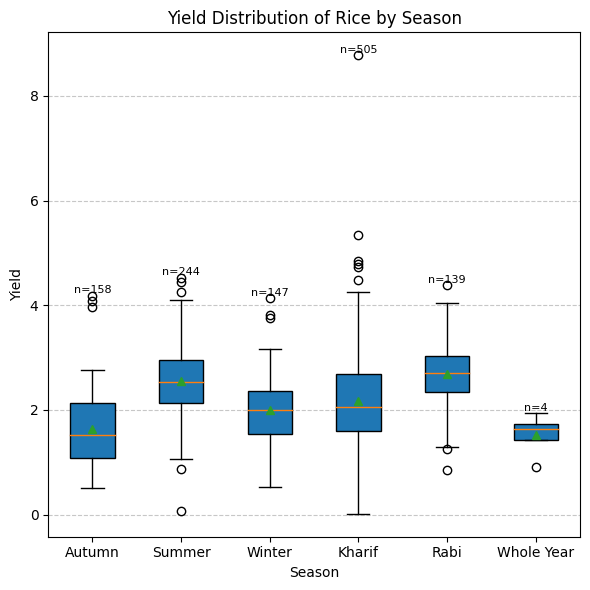

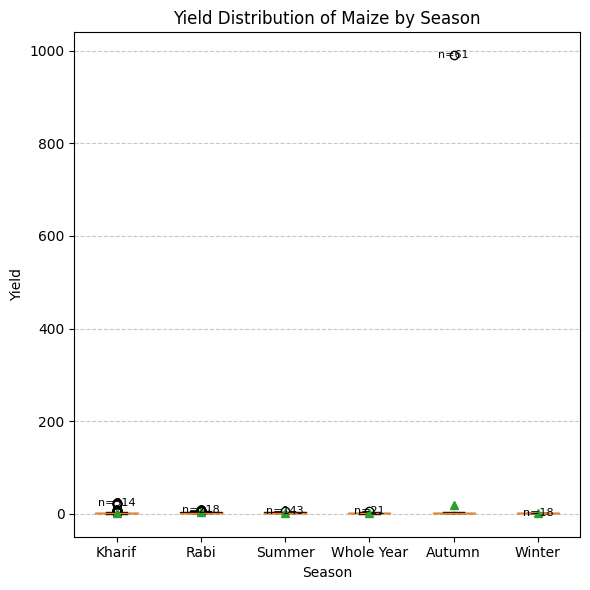

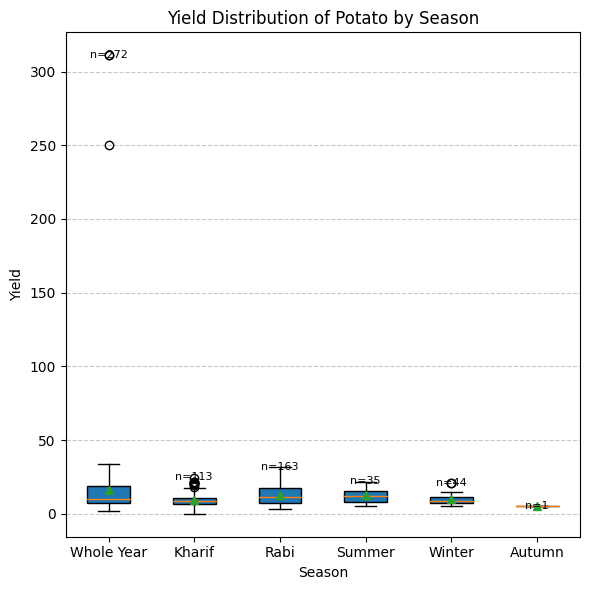

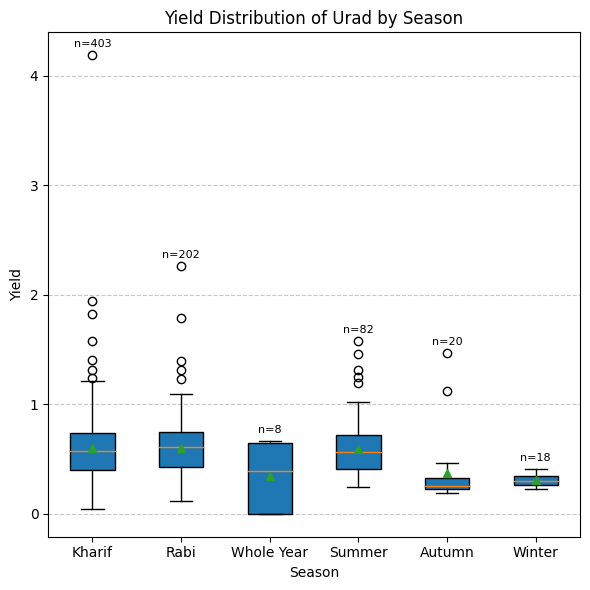

In [11]:
for crop, dataset in DATASET.items():
    seasonal_yields = []
    seasons = dataset['Season'].unique()
    for season in seasons:
        seasonal_yields.append(dataset[dataset['Season'] == season]['Yield'])
    
    data_to_plot = seasonal_yields
    labels = seasons
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)
    
    ax.set_title(f"Yield Distribution of {crop} by Season", fontsize=12)
    ax.set_xlabel("Season", fontsize=10)
    ax.set_ylabel("Yield", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    for i, values in enumerate(data_to_plot):
        count = len(values)
        x_position = i + 1
        y_position = max(values) + 0.1
        ax.text(x_position, y_position, f"n={count}", ha="center", va="center", fontsize=8, color="black")
    
    plt.tight_layout()
    plt.savefig(f"yield_dist_{crop}.png")
    plt.show()

In [12]:
threshold = 3

for crop, dataset in DATASET.items():
    z_scores = dataset.select_dtypes(include=[float, int]).apply(zscore)
    DATASET[crop] = dataset[(z_scores.abs() < threshold).all(axis=1)]

Calculating Correlations

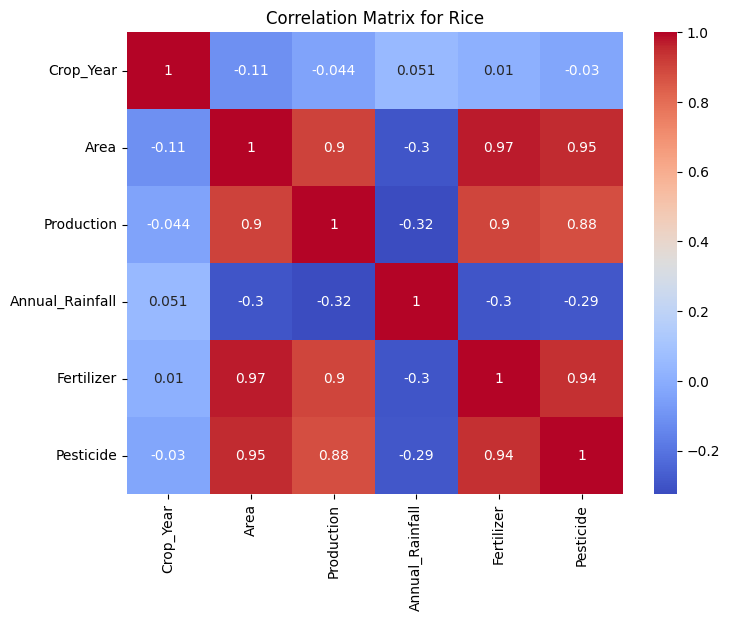

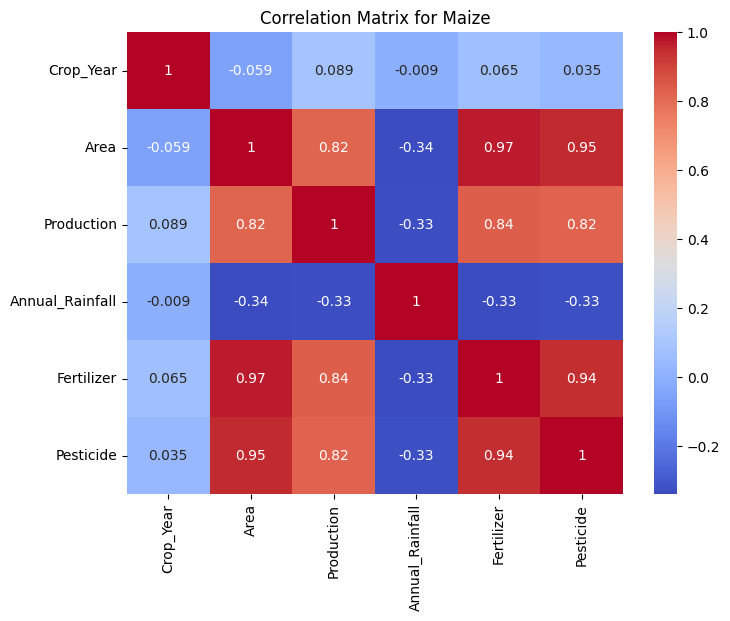

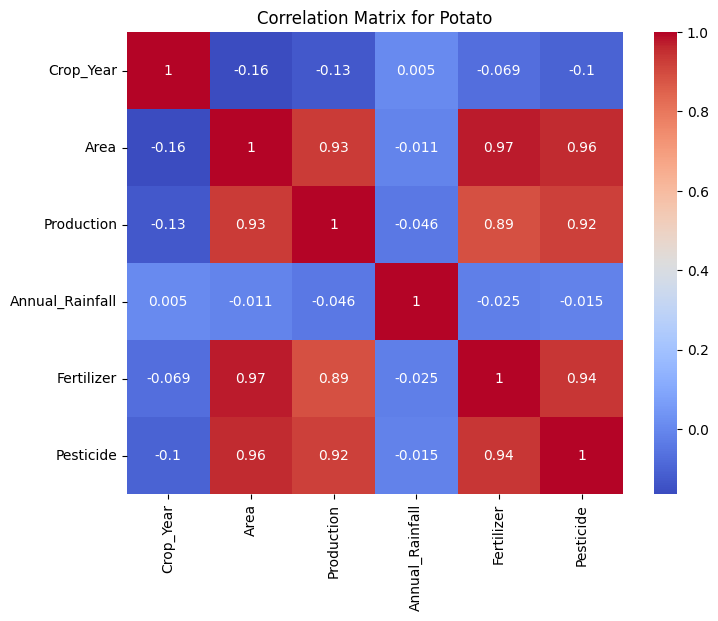

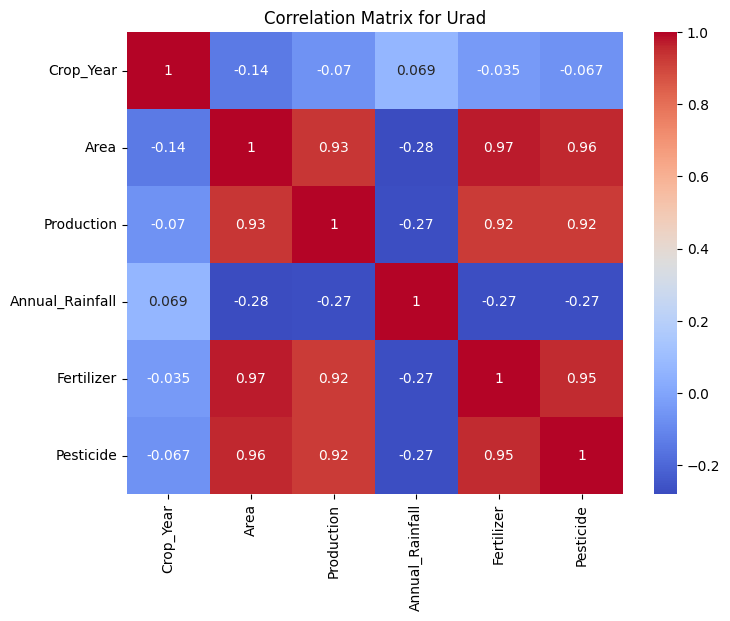

In [13]:
for crop, dataset in DATASET.items():
    corr_matrix = dataset[["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    
    plt.title(f"Correlation Matrix for {crop}")
    plt.savefig(f"corr_mat_unscaled_{crop}.png")
    plt.show()

As our data is variably scaled, we normalise it using standard scaler i.e. (x-u)/s

https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

In [14]:
for crop, dataset in DATASET.items():
    summary = dataset.describe()
    print(f"Ranges for {crop}:", end="\n\n")

    for column in dataset.columns:
        if(column == "Crop" or column == "Season" or column == "State"): continue;
        min_val = summary.loc['min', column] 
        max_val = summary.loc['max', column]
        print(f"{column}: {min_val} - {max_val}")
    
    print(f"{'--' * 20}\n")

Ranges for Rice:

Crop_Year: 1997.0 - 2020.0
Area: 7.0 - 4501000.0
Production: 6.0 - 10837000.0
Annual_Rainfall: 301.3 - 4472.3
Fertilizer: 1162.77 - 625283490.9
Pesticide: 1.68 - 1313843.24
Yield: 0.016666667 - 4.53
----------------------------------------

Ranges for Maize:

Crop_Year: 1997.0 - 2020.0
Area: 6.0 - 907927.0
Production: 0.0 - 2436849.0
Annual_Rainfall: 301.3 - 3616.7
Fertilizer: 571.02 - 128861314.4
Pesticide: 1.86 - 264900.58
Yield: 0.0 - 22.38
----------------------------------------

Ranges for Potato:

Crop_Year: 1997.0 - 2020.0
Area: 3.0 - 394083.0
Production: 0.0 - 8398200.0
Annual_Rainfall: 301.3 - 3870.8
Fertilizer: 515.28 - 55210722.24
Pesticide: 1.11 - 102461.58
Yield: 0.0 - 33.775
----------------------------------------

Ranges for Urad:

Crop_Year: 1997.0 - 2020.0
Area: 2.0 - 633600.0
Production: 0.0 - 379722.0
Annual_Rainfall: 301.3 - 2992.9
Fertilizer: 343.52 - 100379491.7
Pesticide: 0.74 - 214879.36
Yield: 0.0 - 1.472352941
------------------------------

In [15]:
columns_to_scale = ["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]

for crop, dataset in DATASET.items():
    scaler = StandardScaler()
    
    scaled_values = scaler.fit_transform(dataset[columns_to_scale])
    
    dataset_scaled = dataset.copy()
    dataset_scaled[columns_to_scale] = scaled_values
    
    DATASET[crop] = dataset_scaled

Calculating correlations of scaled data

In [16]:
for crop, dataset in DATASET.items():
    summary = dataset.describe()
    ranges = summary.loc['max'] - summary.loc['min']
    print(f"Ranges for {crop}", end="\n\n")
    print(ranges, end=f"\n{'--'*20}\n")

Ranges for Rice

Crop_Year          3.551190
Area               4.608875
Production         4.798250
Annual_Rainfall    4.979269
Fertilizer         4.843198
Pesticide          5.049951
Yield              4.513333
dtype: float64
----------------------------------------
Ranges for Maize

Crop_Year           3.534033
Area                4.710554
Production          4.925837
Annual_Rainfall     5.283948
Fertilizer          4.965094
Pesticide           5.076435
Yield              22.380000
dtype: float64
----------------------------------------
Ranges for Potato

Crop_Year           3.629667
Area                7.350355
Production          7.811363
Annual_Rainfall     5.226015
Fertilizer          8.604439
Pesticide           7.236726
Yield              33.775000
dtype: float64
----------------------------------------
Ranges for Urad

Crop_Year          3.660698
Area               4.358047
Production         4.901048
Annual_Rainfall    5.063025
Fertilizer         5.087644
Pesticide          

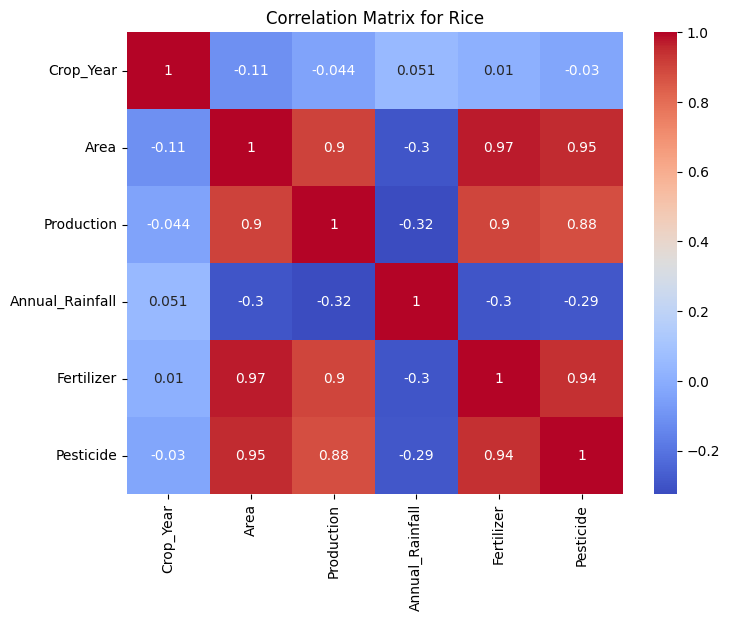

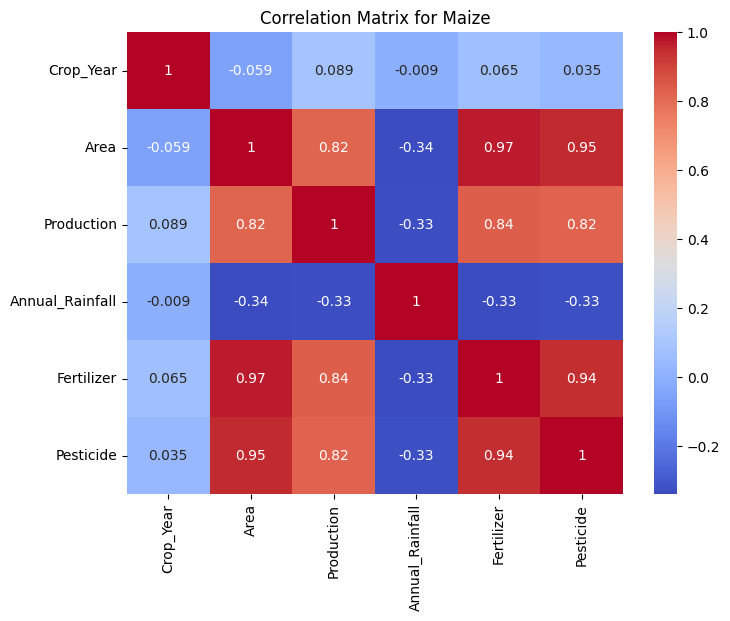

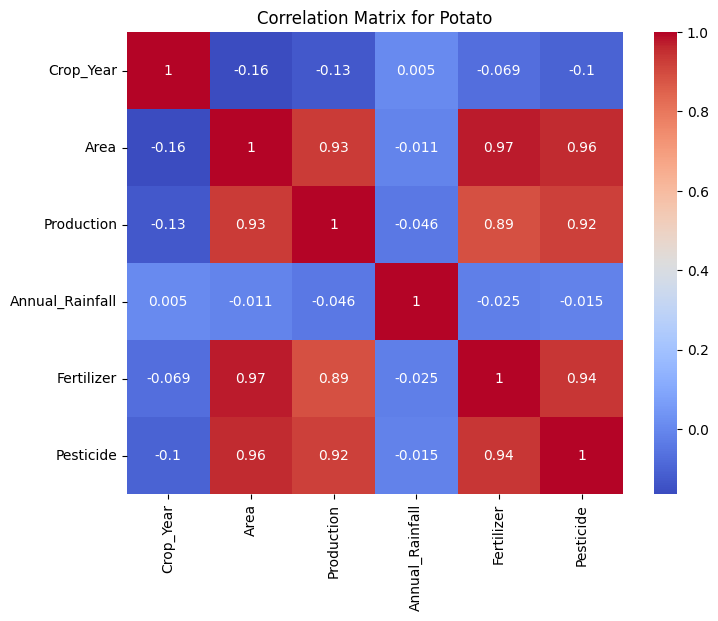

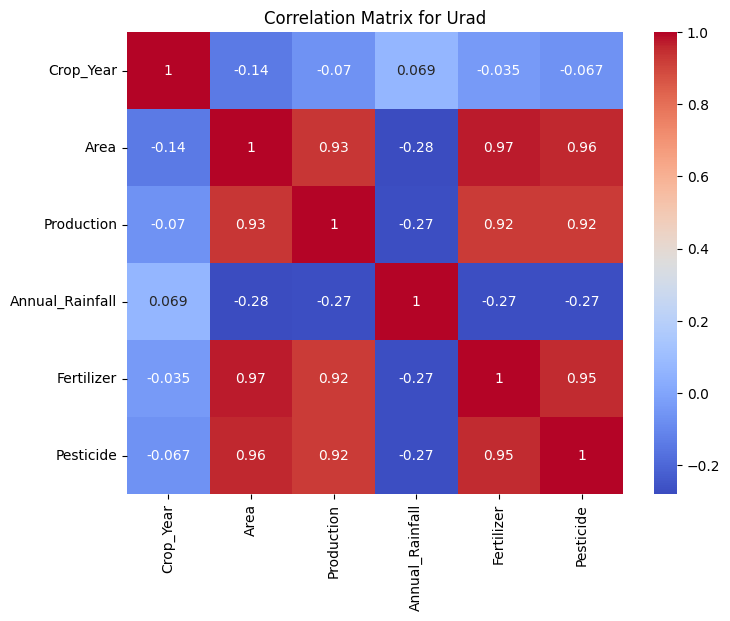

In [17]:
for crop, dataset in DATASET.items():
    corr_matrix = dataset[["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    
    plt.title(f"Correlation Matrix for {crop}")
    plt.savefig(f"corr_mat_scaled_{crop}.png")
    plt.show()

Because there a string data for columns (Season, State), our model cannot process it.
So we converted string data to numerical by assigning different numerical values to each season in **Season** column and state in **State** column.

Label Encoder: https://scikit-learn.org/1.5/modules/preprocessing_targets.html#label-encoding

In [18]:
for crop, dataset in DATASET.items():
    dataset = dataset.copy()

    season_encoder = LabelEncoder()
    state_encoder = LabelEncoder()

    dataset['Season_Encoded'] = season_encoder.fit_transform(dataset['Season'])
    dataset['State_Encoded'] = state_encoder.fit_transform(dataset['State'])

    dataset = dataset.drop(labels=['Season', 'State'], axis=1)
    
    DATASET[crop] = dataset

Splitting dataset into train and test (80% and 20%)

In [19]:
features_to_pca = ["Area", "Production", "Fertilizer", "Pesticide"]

for crop, dataset in DATASET.items():
    dataset = dataset.copy()
    
    features = dataset[features_to_pca]
    
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    
    dataset = dataset.drop(columns=features_to_pca)
    
    dataset["PC1"] = pca_features[:, 0]
    dataset["PC2"] = pca_features[:, 1]
    
    DATASET[crop] = dataset

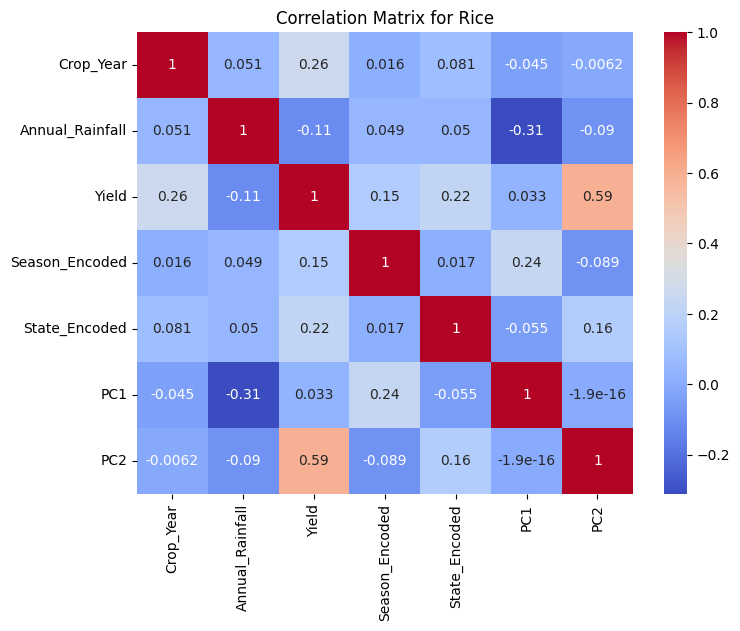

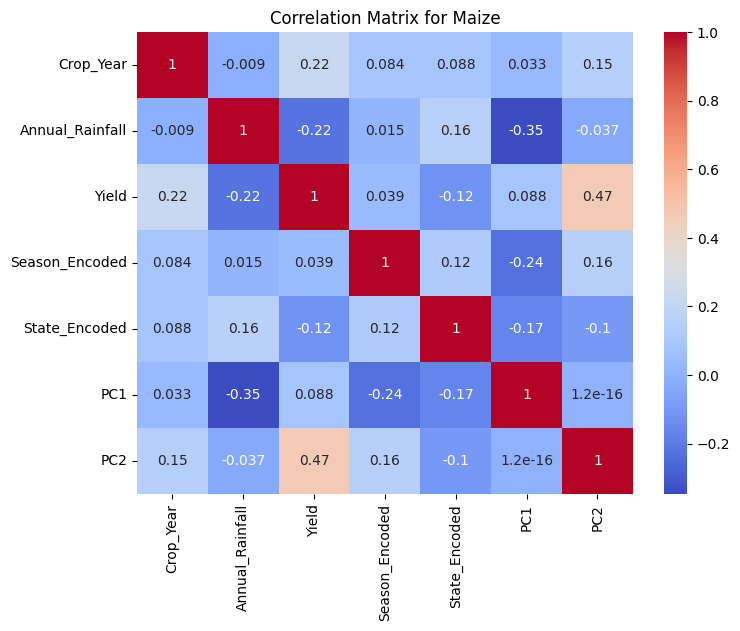

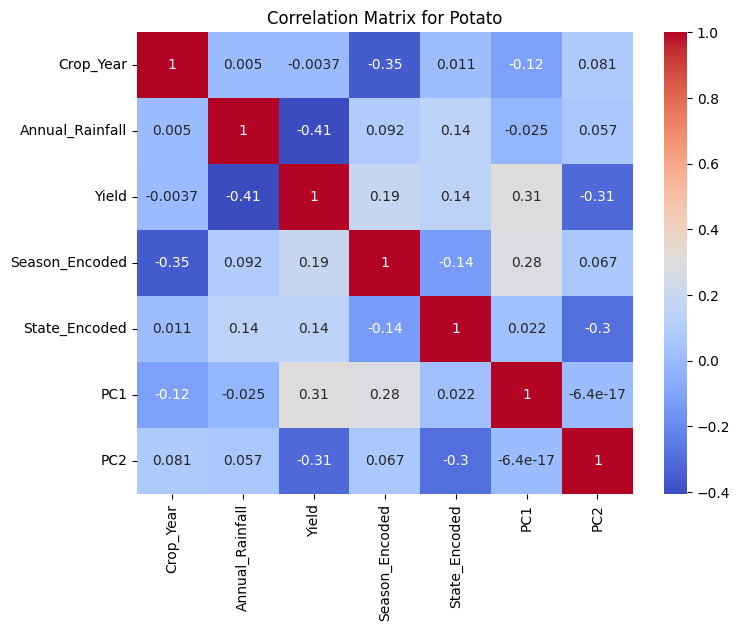

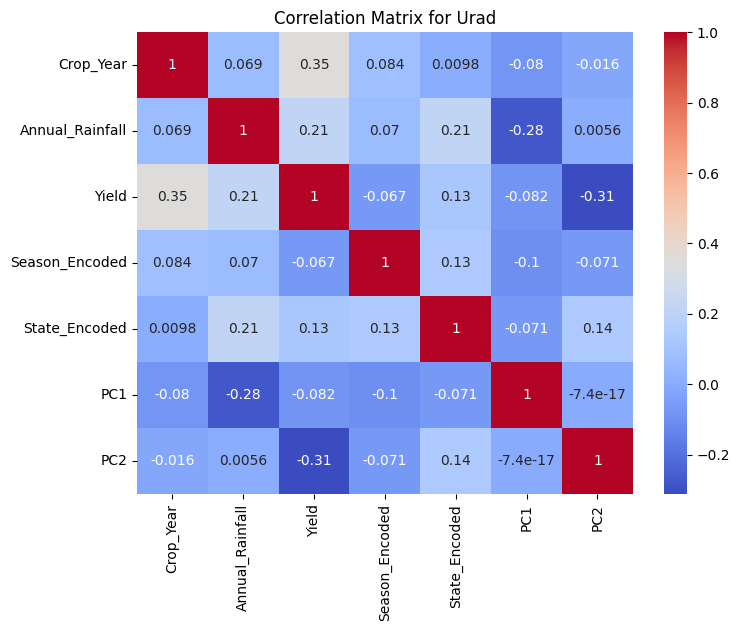

In [20]:
for crop, dataset in DATASET.items():
    corr_matrix = dataset.drop(columns=["Crop"]).corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    
    plt.title(f"Correlation Matrix for {crop}")
    plt.savefig(f"corr_mat_pca_{crop}.png")
    plt.show()

In [21]:
combined_dataset = pd.concat(DATASET.values(), ignore_index=True)

crop_encoder = LabelEncoder()
combined_dataset["Crop_Encoded"] = crop_encoder.fit_transform(combined_dataset["Crop"])

X = combined_dataset[['Crop_Year', 'Annual_Rainfall', 'PC1', 'PC2', 'Season_Encoded', 'State_Encoded', 'Crop_Encoded']]
y = combined_dataset['Yield']

In [22]:
# X = dataset[['Crop_Year', 'Annual_Rainfall', "PC1", "PC2", 'Season_Encoded', 'State_Encoded']]
# y = dataset['Yield']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [24]:
evaluation = {}

Mean Error (ME): 0.1836
Mean Absolute Error (MAE): 2.4643
Mean Squared Error (MSE): 14.3597
Root Mean Squared Error (RMSE): 3.7894
Mean Absolute Percentage Error (MAPE): 139.93%
R² Score: 0.1733


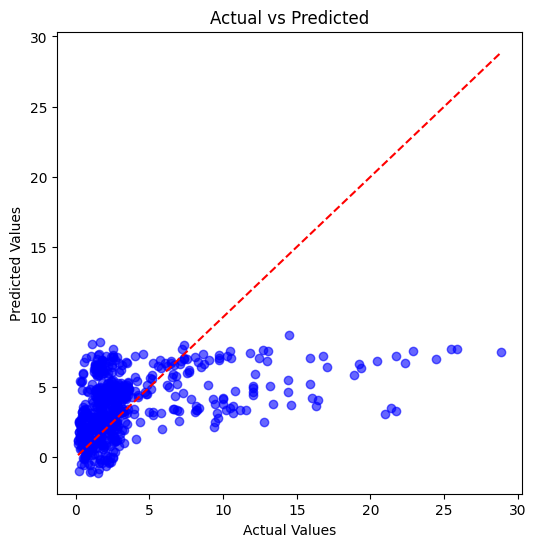

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


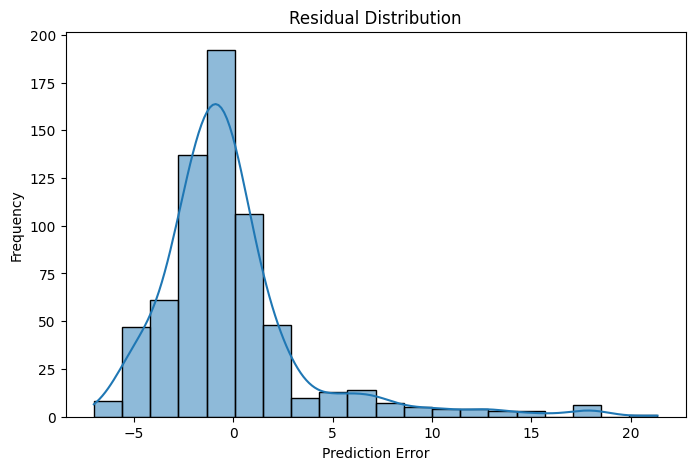

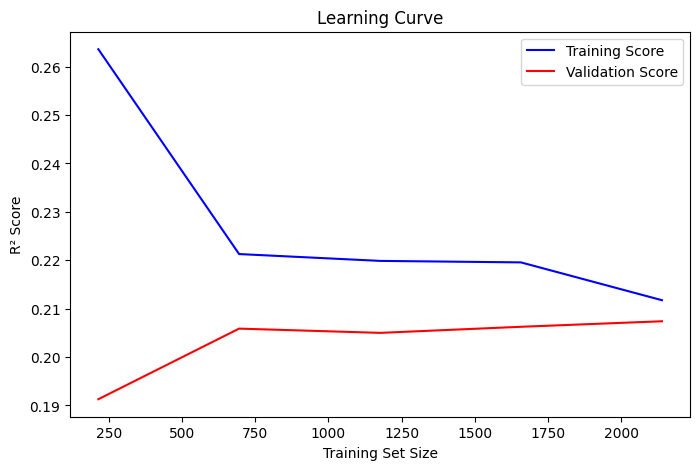

In [25]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Linear Regression'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("linear_line.png")
plt.show()


errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("linear_errors.png")
plt.show()


train_sizes, train_scores, test_scores = learning_curve(linear, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("linear_curve.png")
plt.show()

Using Linear Regression with L2 regularisation

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Mean Error (ME): 0.1838
Mean Absolute Error (MAE): 2.4634
Mean Squared Error (MSE): 14.3580
Root Mean Squared Error (RMSE): 3.7892
Mean Absolute Percentage Error (MAPE): 139.95%
R² Score: 0.1734


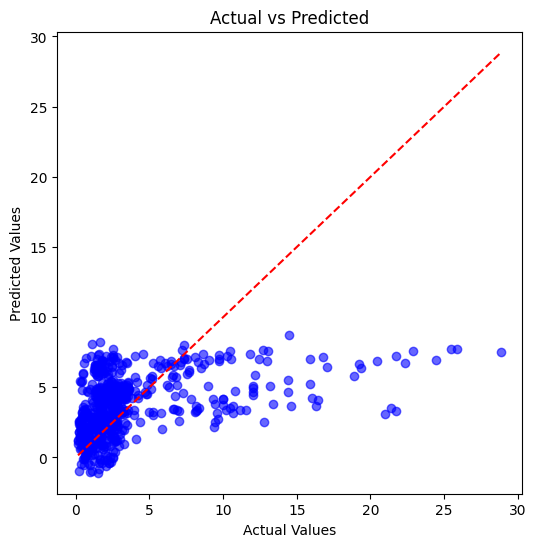

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


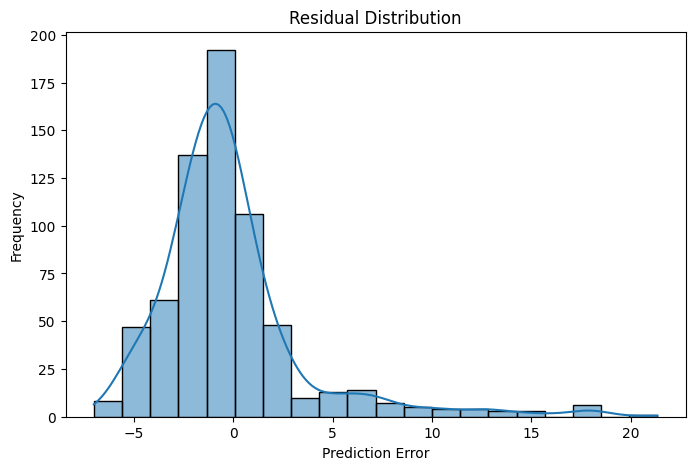

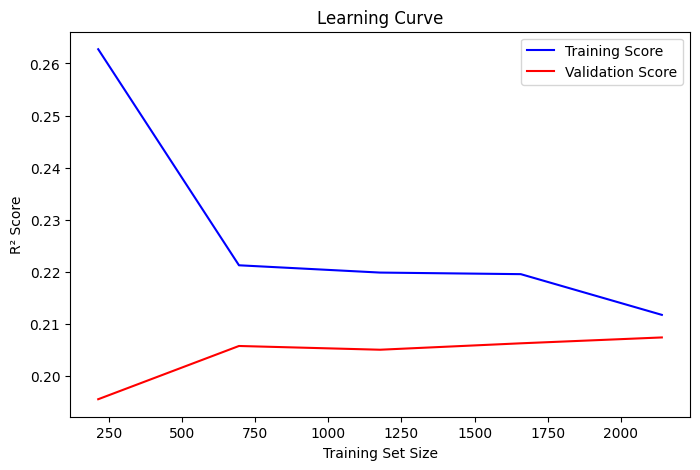

In [26]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Ridge Regression'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("ridge_line.png")
plt.show()



errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("ridge_errors.png")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(ridge, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("ridge_curve.png")
plt.show()

Using Decision Tree regressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

Mean Error (ME): -0.0682
Mean Absolute Error (MAE): 0.4716
Mean Squared Error (MSE): 1.2246
Root Mean Squared Error (RMSE): 1.1066
Mean Absolute Percentage Error (MAPE): 15.41%
R² Score: 0.9295


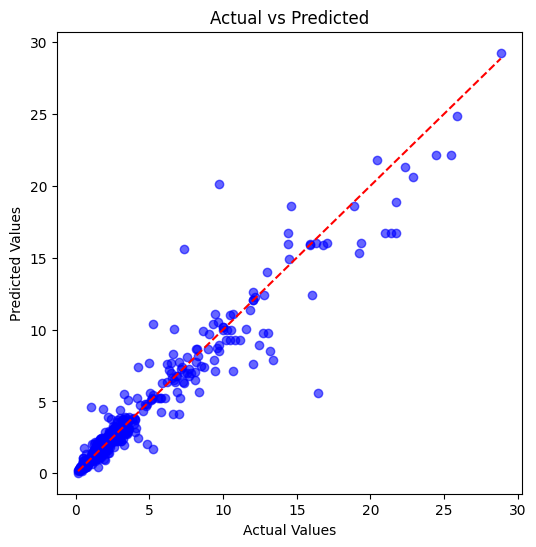

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


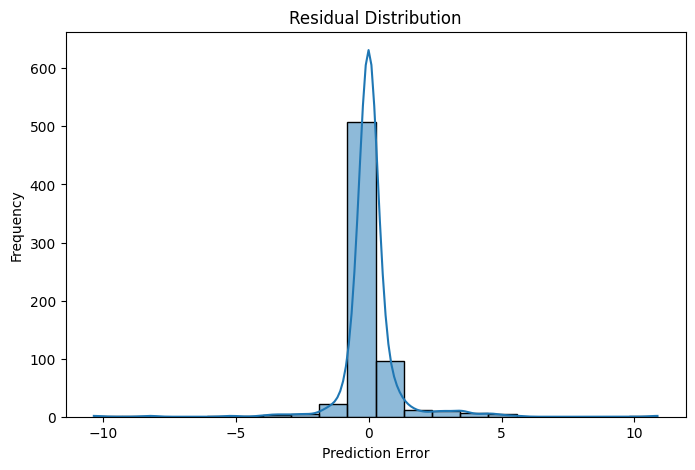

Index(['Crop_Year', 'Annual_Rainfall', 'PC1', 'PC2', 'Season_Encoded',
       'State_Encoded', 'Crop_Encoded'],
      dtype='object') [0.01522389 0.03655278 0.0731961  0.17168054 0.00708124 0.04202765
 0.65423781]


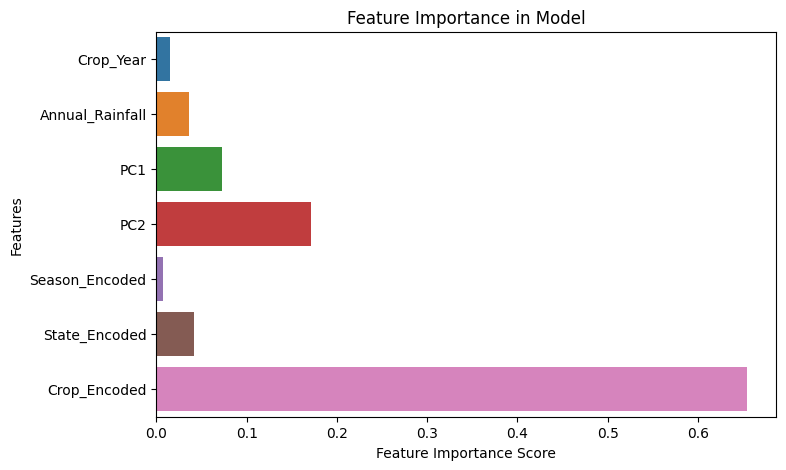

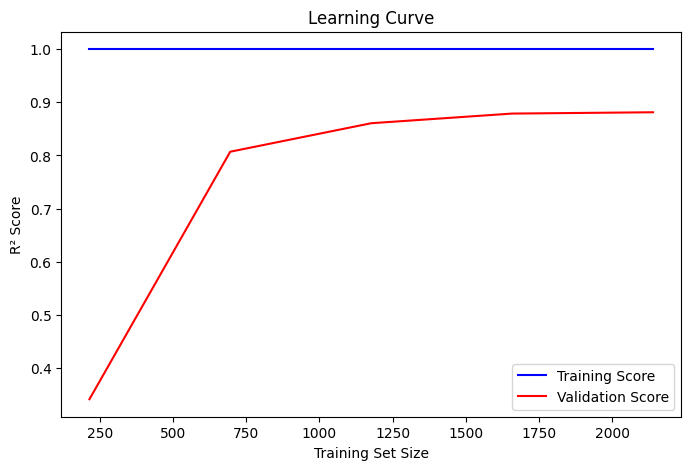

In [27]:
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Decision Tree'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("decision_line.png")
plt.show()

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("decision_errors.png")
plt.show()

importances = decision_tree.feature_importances_
features = X_train.columns

print(features, importances)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Model")
plt.savefig("decision_imp.png")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(decision_tree, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("decision_curve.png")
plt.show()

Using Random Forest ensemble regressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Mean Error (ME): -0.0375
Mean Absolute Error (MAE): 0.4020
Mean Squared Error (MSE): 0.8709
Root Mean Squared Error (RMSE): 0.9332
Mean Absolute Percentage Error (MAPE): 13.75%
R² Score: 0.9499


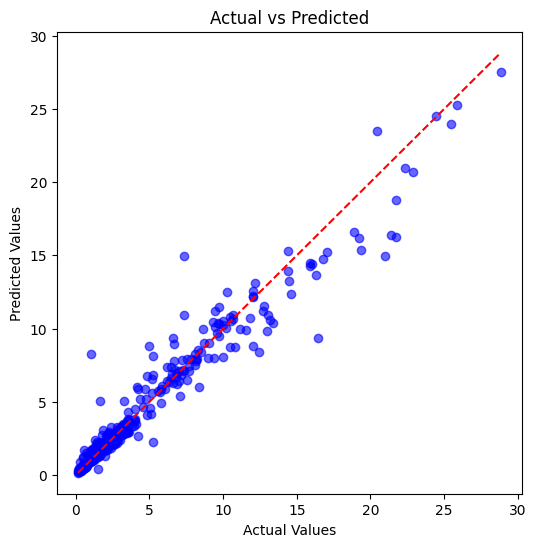

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


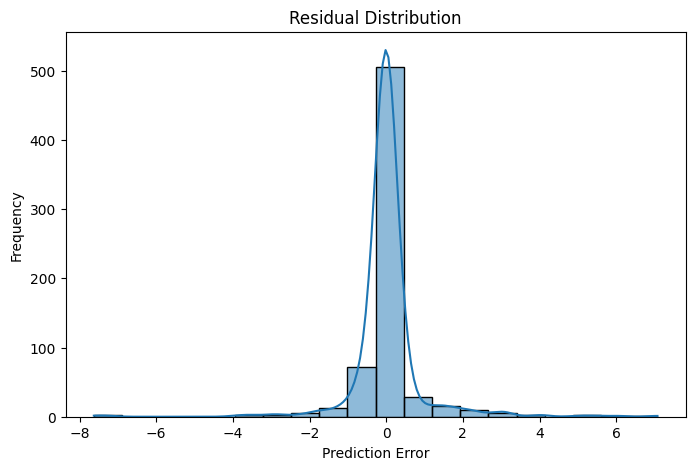

Index(['Crop_Year', 'Annual_Rainfall', 'PC1', 'PC2', 'Season_Encoded',
       'State_Encoded', 'Crop_Encoded'],
      dtype='object') [0.01401054 0.04282918 0.06656837 0.18399424 0.01489413 0.02984548
 0.64785806]


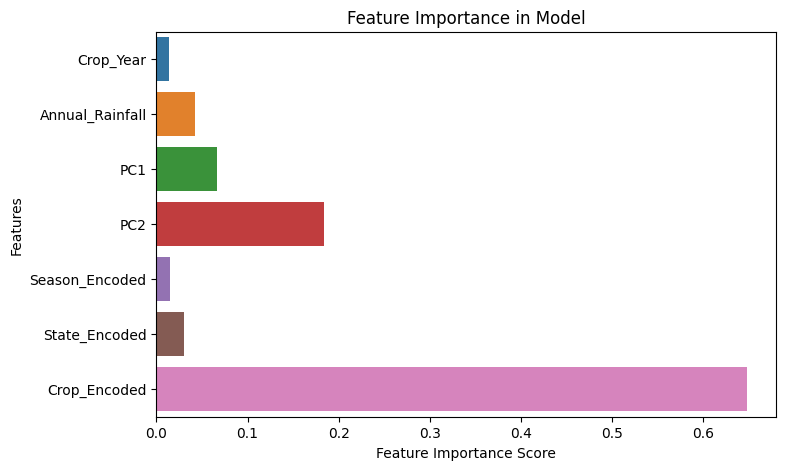

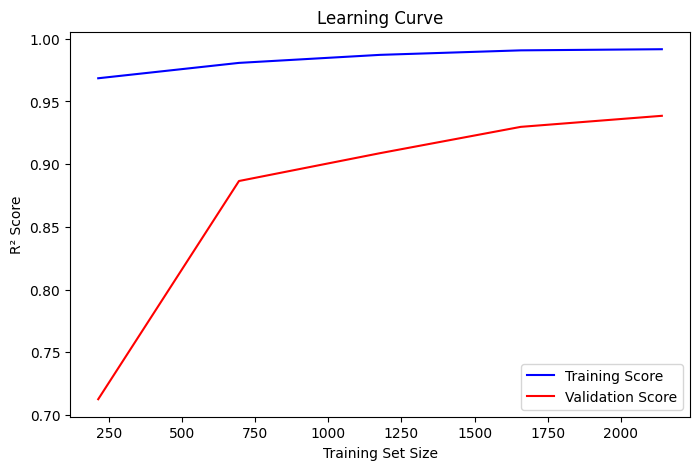

In [28]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Random Forest'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("forest_line.png")
plt.show()

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("forest_errors.png")
plt.show()

importances = forest.feature_importances_
features = X_train.columns

print(features, importances)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Model")
plt.savefig("forest_imp.png")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(forest, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("forest_curve.png")
plt.show()

Using Gradient Boosted regressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

Mean Error (ME): -0.0518
Mean Absolute Error (MAE): 0.7131
Mean Squared Error (MSE): 1.9787
Root Mean Squared Error (RMSE): 1.4067
Mean Absolute Percentage Error (MAPE): 30.30%
R² Score: 0.8861


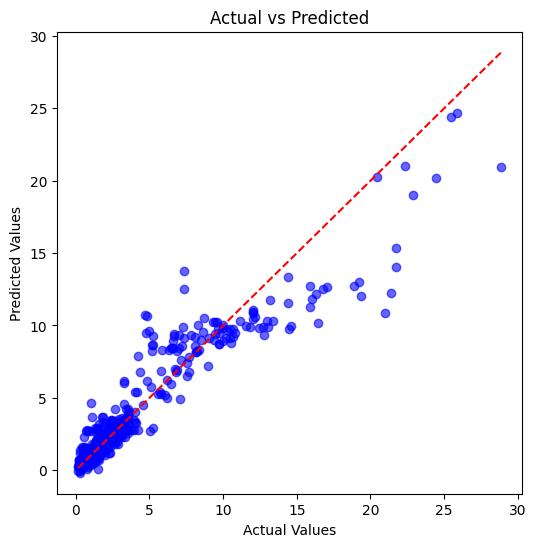

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


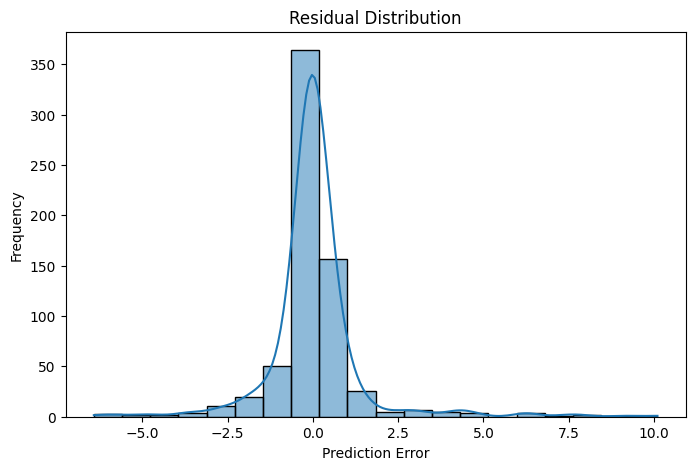

Index(['Crop_Year', 'Annual_Rainfall', 'PC1', 'PC2', 'Season_Encoded',
       'State_Encoded', 'Crop_Encoded'],
      dtype='object') [0.00784453 0.04477248 0.04460439 0.15818426 0.01833865 0.01728858
 0.70896712]


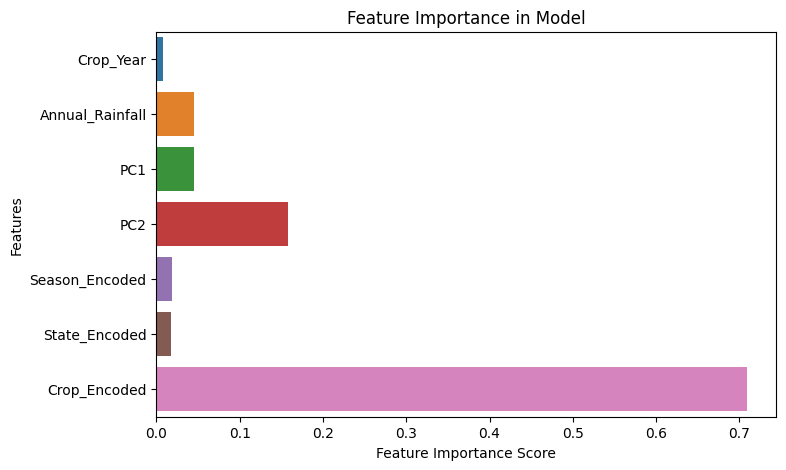

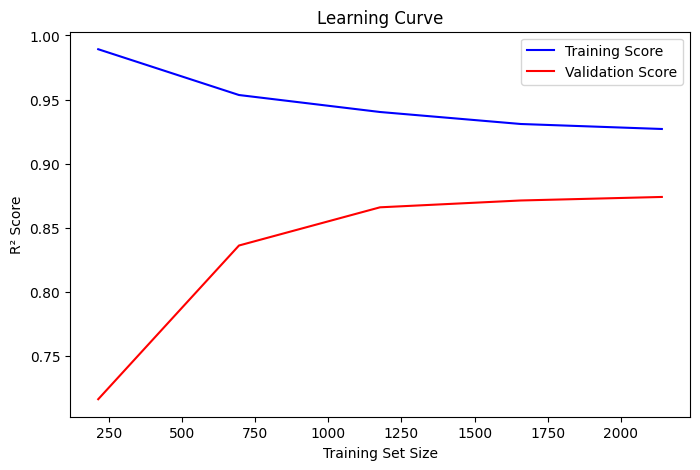

In [29]:
gradient_boost = GradientBoostingRegressor(random_state=42)
gradient_boost.fit(X_train, y_train)

y_pred = gradient_boost.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Gradient Boosted'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("gradient_line.png")
plt.show()

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("gradient_errors.png")
plt.show()

importances = gradient_boost.feature_importances_
features = X_train.columns

print(features, importances)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Model")
plt.savefig("gradient_imp.png")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(gradient_boost, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("gradient_curve.png")
plt.show()

Using Multi-Layer Perceptron regressor

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

Mean Error (ME): -0.0427
Mean Absolute Error (MAE): 0.9355
Mean Squared Error (MSE): 2.5437
Root Mean Squared Error (RMSE): 1.5949
Mean Absolute Percentage Error (MAPE): 47.79%
R² Score: 0.8536


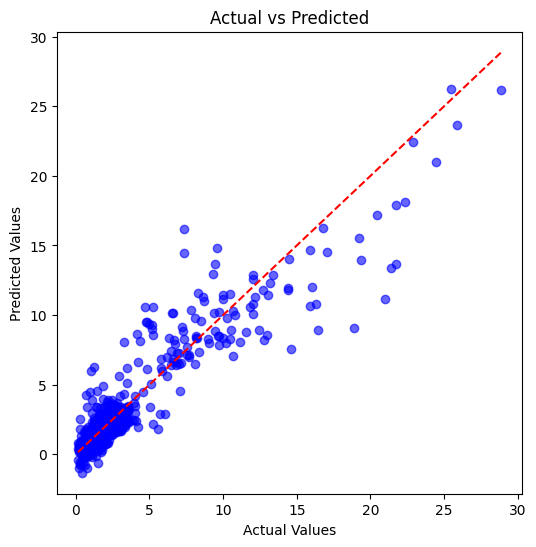

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


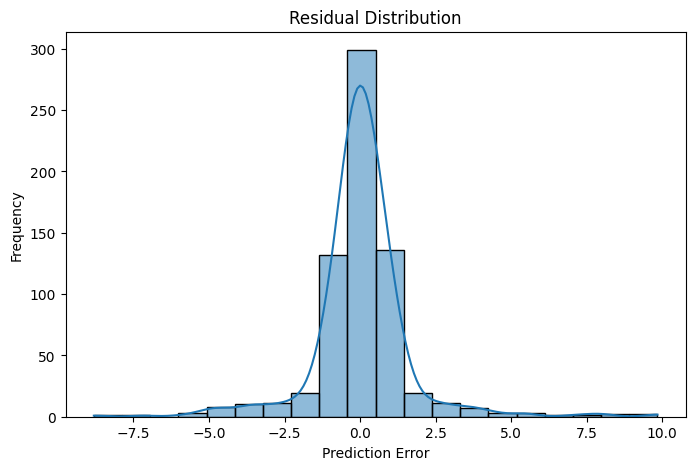

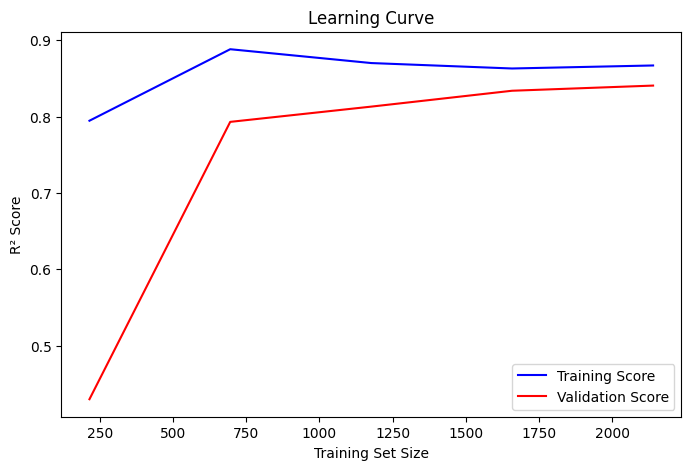

In [30]:
mlp = MLPRegressor(random_state=20, max_iter=10000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Error (ME): {me:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

evaluation['Multilayer Perceptron'] = {
    "ME": me,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2
}

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.savefig("mlp_line.png")
plt.show()


errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.savefig("mlp_errors.png")
plt.show()

train_sizes, train_scores, test_scores = learning_curve(mlp, X_train, y_train, cv=5, scoring="r2")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation Score", color='red')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("mlp_curve.png")
plt.show()

In [31]:
df = pd.DataFrame(evaluation).T
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

metrics = ["ME", "MAE", "MSE", "RMSE", "MAPE", "R2"]
palette = sns.color_palette("viridis", len(df["Model"]))  # Get colors for models

for metric in metrics:
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x="Model", y=metric, data=df, palette=palette)

    # Remove x-axis labels
    ax.set_xticks([])
    ax.set_xlabel("")

    # Manually create a color-matched legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(df["Model"]))]
    plt.legend(handles, df["Model"], title="Model", loc="upper right", fontsize=8)

    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.savefig(f"compare-{metric}.png")
    plt.close()  # Close figure to prevent overlap

plt.show()

In [32]:
evaluation

{'Linear Regression': {'ME': 0.18355671354028372,
  'MAE': 2.4643431004168836,
  'MSE': 14.35965696419499,
  'RMSE': 3.789413802185635,
  'MAPE': 139.9335217441294,
  'R2': 0.17325857479217954},
 'Ridge Regression': {'ME': 0.1837971504242338,
  'MAE': 2.463435812172263,
  'MSE': 14.35798253212874,
  'RMSE': 3.7891928602446114,
  'MAPE': 139.94744962630205,
  'R2': 0.17335497837315061},
 'Decision Tree': {'ME': -0.06816120035575485,
  'MAE': 0.4716061908310911,
  'MSE': 1.2246352337930555,
  'RMSE': 1.1066323842148555,
  'MAPE': 15.413347180186927,
  'R2': 0.9294929759763559},
 'Random Forest': {'ME': -0.037507560700896954,
  'MAE': 0.4019670356362629,
  'MSE': 0.8709040037393657,
  'RMSE': 0.933222376360193,
  'MAPE': 13.75245937306413,
  'R2': 0.9498586617308483},
 'Gradient Boosted': {'ME': -0.051842975557846734,
  'MAE': 0.7130845550416196,
  'MSE': 1.9787409331677532,
  'RMSE': 1.406677266883827,
  'MAPE': 30.298834089599097,
  'R2': 0.8860761713679369},
 'Multilayer Perceptron': {

In [33]:
param_grids = {
    'Linear': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters for basic Linear Regression
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {'max_depth': [5, 10, 20, None],
                   'min_samples_split': [2, 5, 10]}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'n_estimators': [50, 100, 200],
                   'max_depth': [5, 10, None],
                   'min_samples_split': [2, 5, 10]}
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [50, 100, 200],
                   'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 5, 10]}
    },
    'MLP': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50,50)],
                   'activation': ['relu', 'tanh'],
                   'alpha': [0.0001, 0.001, 0.01]}
    }
}


In [34]:
best_models = {}

for name, config in param_grids.items():
    print(f"Tuning {name}...")
    
    search = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
    
    search.fit(X_train, y_train)  # Fit the model
    
    best_models[name] = search.best_estimator_  # Store the best model
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best R² score: {search.best_score_}\n")

for name, model in best_models.items():
    test_score = model.score(X_test, y_test)
    print(f"{name} Test R² Score: {test_score:.4f}")

Tuning Linear...
Best parameters for Linear: {}
Best R² score: 0.20739985654805437

Tuning Ridge...
Best parameters for Ridge: {'alpha': 10}
Best R² score: 0.20741465972492418

Tuning DecisionTree...
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 5}
Best R² score: 0.893229768978629

Tuning RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best R² score: 0.9399802756045561

Tuning GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best R² score: 0.9309828369051436

Tuning MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}
Best R² score: 0.8896525750446915

Linear Test R² Score: 0.1733
Ridge Test R² Score: 0.1734
DecisionTree Test R² Score: 0.9237
RandomForest Test R² Score: 0.9495
GradientBoosting Test R² Score: 0.9583
MLP Test R² Score: 0.8806
